# Checking plate boundary lengths from topological polygons

This is an example for how to test the consistency of the lengths of an arbitrary plate boundary type determined from a set of Topological plate polygons. Errors in topological polygons often occur - a more detailed description and strategies for identifying them are outlined here:  
https://www.gplates.org/docs/pygplates/sample-code/pygplates_detect_topology_gaps_and_overlaps.html

In this notebook, code is presented to compute the total length of given boundary type (eg 'gpml:MidOceanRidge', 'gpml:SubductionZone', etc) in two different ways
1. based on the so-called 'shared_boundary_sections' (which can contain duplicates, gaps) 
2. iterating through each plate polygon and summing the lengths of each boundary type (such that every boundary is counted twice).

The deviation between the two estimates provides an indication of the magnitude of topological errors as a function of time for different plate boundary types.


In [8]:
import pygplates
import math
import numpy as np
import matplotlib.pyplot as plt
import glob

%matplotlib inline

# Define a function to compute the lengths for a given boundary type, time range 
# and time increment
def BoundaryLengthCheck(GPML_List,RotFile_List,min_time,max_time,time_step,
                        BoundaryType='SubductionZone'):

    rotation_model = pygplates.RotationModel(RotFile_List)
    topology_features = pygplates.FeatureCollection()
    for file in GPML_List:
        topology_feature = pygplates.FeatureCollection(file)
        topology_features.add(topology_feature)
    #'''

    SL1_length = []
    SL2_length = []

    times = np.arange(min_time,max_time + 1,time_step)
    # 'time' = 0, 1, 2, ... , max time
    for time in times:

        # Resolve our topological plate polygons (and deforming networks) to the current 'time'.
        # We generate both the resolved topology boundaries and the boundary sections between them.
        resolved_topologies = []
        shared_boundary_sections = []
        pygplates.resolve_topologies(topology_features, rotation_model, resolved_topologies, time, shared_boundary_sections)

        # We will accumulate the total ridge and subduction zone lengths for the current 'time'.
        total_subduction_zone_length_1 = 0
        total_subduction_zone_length_2 = 0

        # Method 1
        for shared_boundary_section in shared_boundary_sections:

            # Iterate over the shared sub-segments to accumulate their lengths.
            shared_sub_segments_length = 0
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():

                # Each sub-segment has a polyline with a length.
                shared_sub_segments_length += shared_sub_segment.get_geometry().get_arc_length()

            if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.create_gpml(BoundaryType):
                total_subduction_zone_length_1 += shared_sub_segments_length            

        # Method 2
        for polygon in resolved_topologies:

            for seg in polygon.get_boundary_sub_segments():   
                if seg.get_resolved_feature().get_feature_type() == pygplates.FeatureType.create_gpml(BoundaryType):
                    total_subduction_zone_length_2 += seg.get_geometry().get_arc_length()


        total_subduction_zone_length_1_in_kms = total_subduction_zone_length_1 * pygplates.Earth.mean_radius_in_kms
        total_subduction_zone_length_2_in_kms = total_subduction_zone_length_2 * pygplates.Earth.mean_radius_in_kms

        SL1_length.append(total_subduction_zone_length_1_in_kms)
        SL2_length.append(total_subduction_zone_length_2_in_kms)
        
    return SL1_length,SL2_length



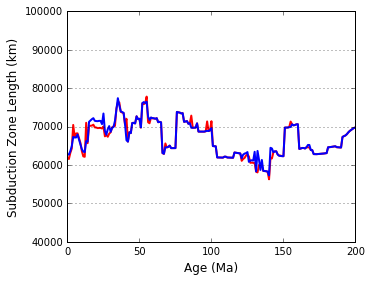

In [9]:
# Run the code for subduction zones from the Muller++2016 reconstruction files
RotFile_List = ['../Data/Global_EarthByte_230-0Ma_GK07_AREPS.rot']
GPML_List = ['../Data/Global_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpmlz',
             '../Data/Global_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpmlz']

min_time = 0
max_time = 200
time_step = 1.
    

SL1_length,SL2_length = BoundaryLengthCheck(GPML_List,RotFile_List,min_time,max_time,time_step)

times = np.arange(min_time,max_time + 1,time_step)

fig = plt.figure(figsize=(8,4))

fig.add_axes([0.15, 0.15, 0.5, 0.8])
plt.plot(times,np.array(SL2_length)/2,'r',linewidth=2)
plt.plot(times,np.array(SL1_length),'b',linewidth=2)

plt.ylim((40000,100000))
plt.ylabel('Subduction Zone Length (km)',fontsize=12)
plt.xlim((0,200))
plt.xlabel('Age (Ma)',fontsize=12)
plt.gca().yaxis.grid(True,which='major')

plt.show()

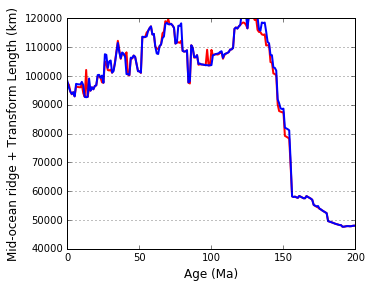

In [10]:
# Repeat for 'MidOceanRidge' boundaries
# [NOTE this includes ridges and transforms]
SL1_length,SL2_length = BoundaryLengthCheck(GPML_List,
                                            RotFile_List,
                                            min_time,
                                            max_time,
                                            time_step,
                                            BoundaryType='MidOceanRidge')

fig = plt.figure(figsize=(8,4))

fig.add_axes([0.15, 0.15, 0.5, 0.8])
plt.plot(times,np.array(SL2_length)/2,'r',linewidth=2)
plt.plot(times,np.array(SL1_length),'b',linewidth=2)

plt.ylim((40000,120000))
plt.ylabel('Mid-ocean ridge + Transform Length (km)',fontsize=12)
plt.xlim((0,200))
plt.xlabel('Age (Ma)',fontsize=12)
plt.gca().yaxis.grid(True,which='major')

plt.show()
